## Importing Libraries

In [1]:
import os
import random
import matplotlib.pyplot as plt
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop,Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import *
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import seaborn as sns
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import Model, load_model,save_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Checking GPU specs

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4154666701245445044, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14108568628174140249
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12291988928574682994
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14640891840
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1923043872690065787
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

## Mouting Google Drive and extracting images to colab workspace 

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Mounted at /content/gdrive
'Colab Notebooks'   Fruits.rar	'GRE 2.pdf'  'My Drive'
 flowers.rar	   'GRE 1.pdf'	 models


In [ ]:
!unrar x /mydrive/Fruits.rar

In [5]:
!mkdir train
!mkdir test

## To check which class folders have sub folder

In [6]:
classes = [i for i in os.listdir('Fruits/Train') ]

folder1=[]
folder2=[]
for i in classes:
  if not os.listdir('Fruits/Train/'+i)[0].endswith('.jpg'):
    folder1.append(i)
  else:
    folder2.append(i)
folder1,folder2      

(['Tomato',
  'Apple',
  'Peach',
  'Strawberry',
  'Banana',
  'Cherry',
  'Onion',
  'Corn'],
 ['Cauliflower',
  'Orange',
  'Eggplant',
  'Dates',
  'Carambula',
  'Lychee',
  'Ginger',
  'Mulberry',
  'Capsicum',
  'Watermelon'])

In [7]:
for i in classes:
  os.mkdir('train/'+i)
  os.mkdir('test/'+i)

## Copying images to their respective folders

In [8]:
for i in folder1:
  sub_folder = [j for j in os.listdir('Fruits/Train/'+i)]
  count=0
  for sub_folder_names in sub_folder:
    for file_name in  os.listdir('Fruits/Train/'+i+'/'+sub_folder_names):
      count+=1
      copyfile('Fruits/Train/'+i+'/'+sub_folder_names+'/'+file_name, 'train/'+i+'/'+str(count)+'.jpg')

In [9]:
for i in folder1:
  sub_folder = [j for j in os.listdir('Fruits/Test/'+i)]
  count=0
  for sub_folder_names in sub_folder:
    for file_name in  os.listdir('Fruits/Test/'+i+'/'+sub_folder_names):
      count+=1
      copyfile('Fruits/Test/'+i+'/'+sub_folder_names+'/'+file_name, 'test/'+i+'/'+str(count)+'.jpg')

In [10]:
for i in folder2:
  count=0
  for file_name in os.listdir('Fruits/Train/'+i):
    count+=1
    src = 'Fruits/Train/'+i+'/'+file_name
    dest = 'train/'+i+'/'+str(count)+'.jpg'
    copyfile(src,dest)  

In [11]:
for i in folder2:
  count=0
  for file_name in os.listdir('Fruits/Test/'+i):
    count+=1
    src = 'Fruits/Test/'+i+'/'+file_name
    dest = 'test/'+i+'/'+str(count)+'.jpg'
    copyfile(src,dest)  

## Data Visualisation

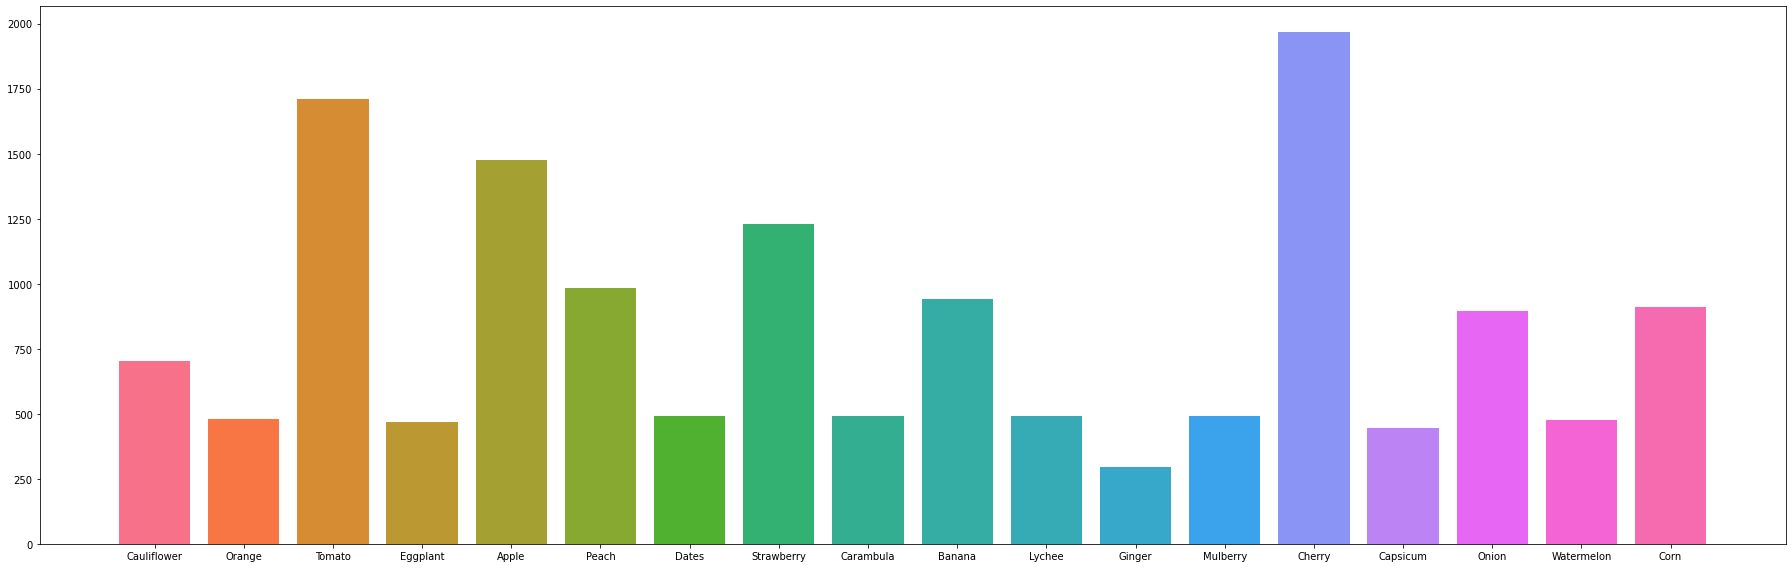

In [12]:
train_class = []
train_class_count = []
for class_name in os.listdir('train'):
   train_class.append(class_name)
   train_class_count.append(len(os.listdir('train/'+class_name)))

fig = plt.figure(figsize=(25,8))
plt.bar(train_class,train_class_count, color = sns.color_palette("husl",len(train_class)))
fig.tight_layout()

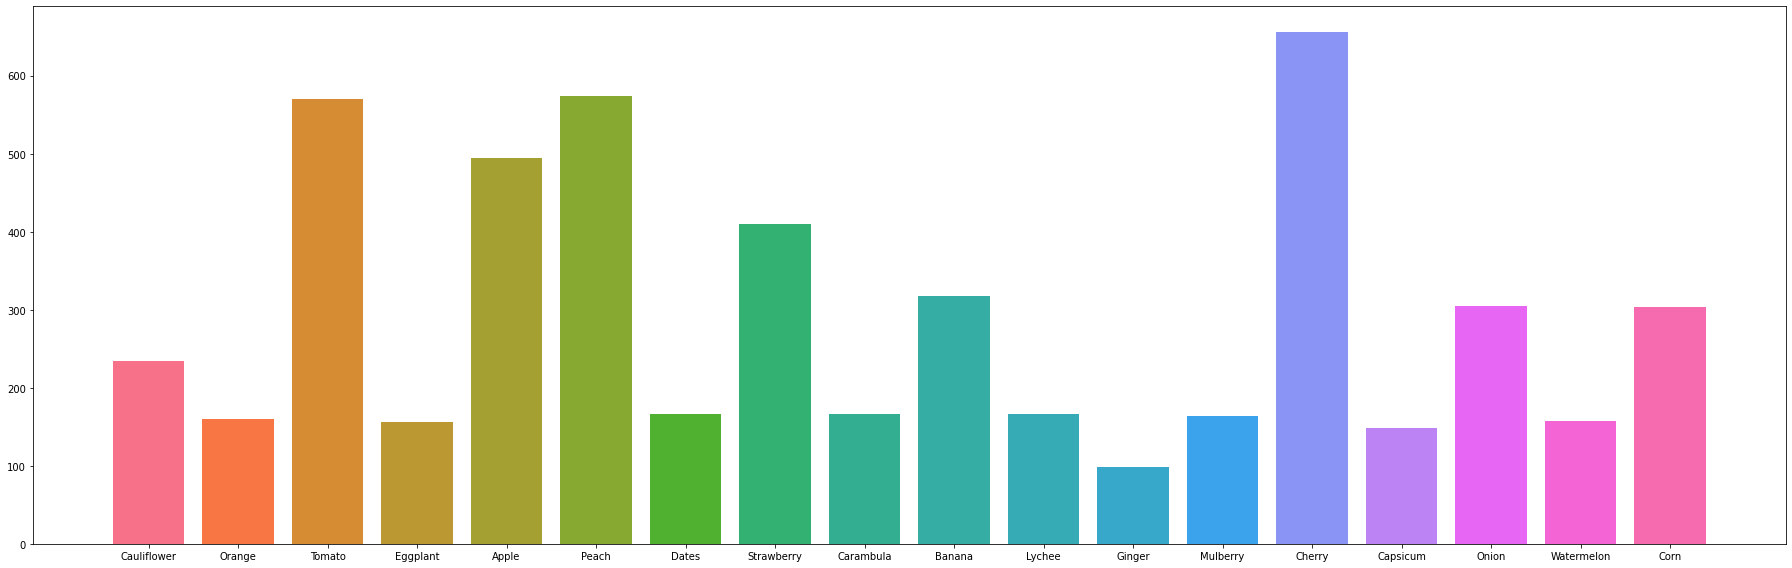

In [13]:
test_class = []
test_class_count = []
for class_name in os.listdir('test'):
   test_class.append(class_name)
   test_class_count.append(len(os.listdir('test/'+class_name)))

fig = plt.figure(figsize=(25,8))
plt.bar(test_class,test_class_count, color = sns.color_palette("husl",len(test_class)))
fig.tight_layout()

In [14]:
def graphs(History):
  plt.plot(History.history['loss'])
  plt.plot(History.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['train', 'test'])
  plt.show()

  plt.plot(History.history['accuracy'])
  plt.plot(History.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend(['train', 'test'])
  plt.show()

## Data Preprocessing

In [15]:
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    )
# rotation_range=30,
#       width_shift_range=0.2,
#       height_shift_range=0.2,
#       shear_range=0.3,
#       zoom_range=0.3,
#       brightness_range=(-0.4,0.4),
#       fill_mode='nearest'

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	'train',
	target_size=(256,256),
	class_mode='categorical',
  batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
	'test',
	target_size=(256,256),
	class_mode='categorical',
  batch_size=32
)

Found 14939 images belonging to 18 classes.
Found 5247 images belonging to 18 classes.


# **Model**

### Call Backs

In [21]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [ ]:
checkpointer = ModelCheckpoint(filepath="weights_c1.hdf5", verbose=1, save_best_only=True)

### Pre-trained InceptionResnetV2

In [16]:
model1 = InceptionResNetV2(weights = 'imagenet', include_top = False, input_shape=(96,96,3))
model1.trainable = False

219062272/219055592 [==============================] - 4s 0us/step


In [ ]:
model1.summary()

In [23]:
 inceptionresnetv2 = model1.output
 inceptionresnetv2 = GlobalAveragePooling2D(name = 'global_average_pool')(inceptionresnetv2)
 inceptionresnetv2 = Flatten(name= 'flatten')(inceptionresnetv2)
 inceptionresnetv2 = Dense(512, activation = "relu", name = 'dense_1')(inceptionresnetv2)
 inceptionresnetv2 = Dropout(0.3)(inceptionresnetv2)
 inceptionresnetv2 = Dense(256, activation = "relu", name = 'dense_2')(inceptionresnetv2)
 inceptionresnetv2 = Dropout(0.3)(inceptionresnetv2)
 inceptionresnetv2 = Dense(18, activation = 'softmax', name = 'dense_3')(inceptionresnetv2)

 final_inceptionresnetv2 = Model(inputs = model1.input, outputs = inceptionresnetv2) 

In [24]:
final_inceptionresnetv2.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [25]:
history_inceptionresnetv2 = final_inceptionresnetv2 .fit(train_generator ,epochs = 10, validation_data= validation_generator, callbacks=[earlystopping])

Epoch 1/10
467/467 [==============================] - 145s 311ms/step - loss: 0.1275 - accuracy: 0.9624 - val_loss: 0.2386 - val_accuracy: 0.9442
Epoch 2/10
467/467 [==============================] - 140s 299ms/step - loss: 0.0252 - accuracy: 0.9920 - val_loss: 0.0418 - val_accuracy: 0.9834
Epoch 3/10
467/467 [==============================] - 140s 299ms/step - loss: 0.0268 - accuracy: 0.9919 - val_loss: 0.0586 - val_accuracy: 0.9828
Epoch 4/10
467/467 [==============================] - 140s 299ms/step - loss: 0.0161 - accuracy: 0.9944 - val_loss: 0.0586 - val_accuracy: 0.9815
Epoch 5/10
467/467 [==============================] - 140s 299ms/step - loss: 0.0050 - accuracy: 0.9987 - val_loss: 0.0930 - val_accuracy: 0.9741
Epoch 00005: early stopping


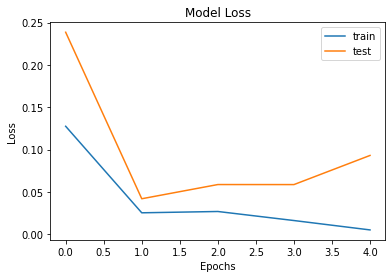

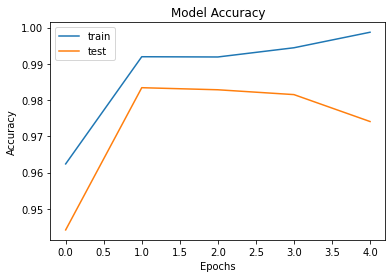

In [26]:
graphs(history_inceptionresnetv2)

In [ ]:
save_model(final_inceptionresnetv2,'/mydrive/models/final_inceptionresnetv2.h5')

### Fine Tuning ResNet50

In [ ]:
model2 = ResNet50(weights='imagenet', include_top=False)

In [ ]:
model2.trainable = False

In [ ]:
x = model2.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(25, activation='softmax')(x)
resnet50 = Model(inputs=model2.input, outputs=predictions)

In [ ]:
resnet50.summary()

In [ ]:
resnet50.compile(optimizer=RMSprop(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history_resnet50 = resnet50.fit(train_generator, epochs = 10,shuffle = True, validation_data= validation_generator,callbacks=[checkpointer,earlystopping])

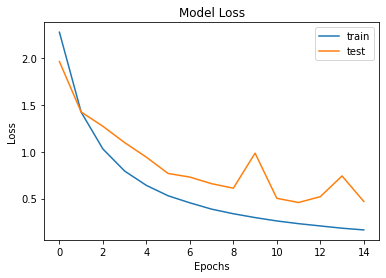

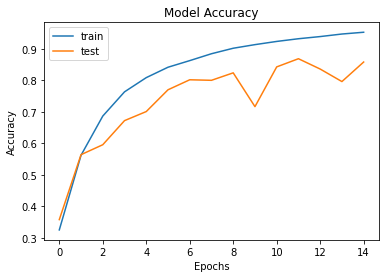

In [ ]:
graphs(history_resnet50)

In [ ]:
img=load_img('w2.jpg', target_size=(, 256,3))
x=img_to_array(img)
x=np.expand_dims(x, axis=0)
out = np.argmax(resnet50.predict(x),axis=-1)
out

array([22])

In [ ]:
save_model(resnet50,'/mydrive/models/resnet50.h5')

### Custom Model 1

In [ ]:
model3 = Sequential()
model3.add(Conv2D(filters = 16, kernel_size = 2,input_shape=(256,256,3),padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=2))

model3.add(Conv2D(filters = 32,kernel_size = 2,activation= 'relu',padding='same'))
model3.add(MaxPooling2D(pool_size=2))

model3.add(Conv2D(filters = 64,kernel_size = 2,activation= 'relu',padding='same'))
model3.add(MaxPooling2D(pool_size=2))

model3.add(Conv2D(filters = 128,kernel_size = 2,activation= 'relu',padding='same'))
model3.add(MaxPooling2D(pool_size=2))

model3.add(Dropout(0.3))
model3.add(Flatten())
model3.add(Dense(150))
model3.add(Activation('relu'))
model3.add(Dropout(0.3))
model3.add(Dense(18,activation = 'softmax'))

In [ ]:
model3.summary()

In [ ]:
model3.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-3),
              metrics=['accuracy'])

In [ ]:
history_custom1=model3.fit(train_generator, epochs = 6, validation_data= validation_generator)

Epoch 1/6
467/467 [==============================] - 31s 66ms/step - loss: 0.3409 - accuracy: 0.8907 - val_loss: 0.5491 - val_accuracy: 0.8822
Epoch 2/6
467/467 [==============================] - 30s 65ms/step - loss: 0.0244 - accuracy: 0.9922 - val_loss: 0.6980 - val_accuracy: 0.9230
Epoch 3/6
467/467 [==============================] - 31s 66ms/step - loss: 0.0297 - accuracy: 0.9908 - val_loss: 0.6861 - val_accuracy: 0.9179
Epoch 4/6
467/467 [==============================] - 31s 66ms/step - loss: 0.0098 - accuracy: 0.9973 - val_loss: 0.6664 - val_accuracy: 0.9102
Epoch 5/6
467/467 [==============================] - 32s 68ms/step - loss: 0.0160 - accuracy: 0.9942 - val_loss: 0.6061 - val_accuracy: 0.9047
Epoch 6/6
467/467 [==============================] - 32s 68ms/step - loss: 0.0214 - accuracy: 0.9934 - val_loss: 0.8701 - val_accuracy: 0.9192


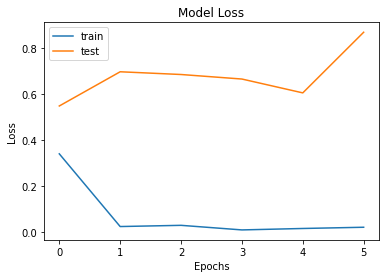

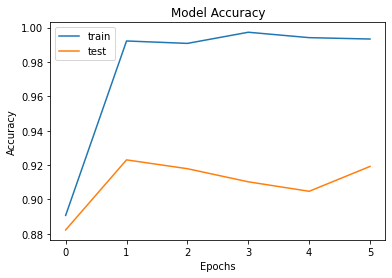

In [ ]:
graphs(history_custom1)

In [ ]:
save_model(model3,'/mydrive/models/customModel1.h5')

### Custom Model 2

In [ ]:
customModel2 = Sequential([
    # The first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(100, 100, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(18, activation='softmax')
])

In [ ]:
customModel2.summary()

In [ ]:
customModel2.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-3),
              metrics=['accuracy'])

In [ ]:
history_customModel2=customModel2.fit(train_generator, epochs = 10, validation_data= validation_generator)

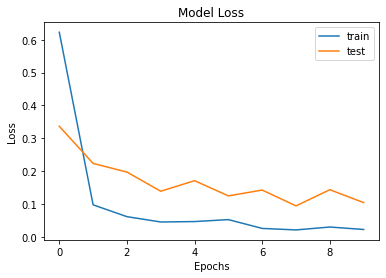

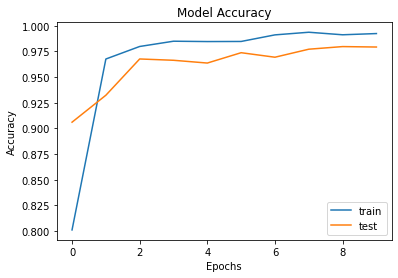

In [ ]:
graphs(history_customModel2)

In [ ]:
save_model(customModel2,'/mydrive/models/customModel2.h5')